In [137]:
# import packages
import pandas as pd
import numpy as np
import re
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 12

# Import  scikit modules
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer
# NLP modules
import nltk 
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import OneHotEncoder 
import spacy
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline




In [138]:
en='en_core_web_sm'
nlp=spacy.load(en)

In [139]:
general_df=pd.read_csv('data/NSS_DS_data.thegeneral.csv')

In [140]:
general_df.head()

,ClaimID_RGEN,ExposureID_RGEN,ClaimLevelBody,ExposureLevelBody,AccidentDescription,InjuryDescription,DamageDescription,SeverityTypeName,ClaimGroup,FaultRatingName,LossCauseName,CCCreateTime,CloseDate,StateName
0,10000,131005,reviewed\r\ncoverage sc rated policy and loss...,none none liability accepted by adverse and da...,the insured was test driving a vehicle the ov...,neckback,front left side damages towed collision tow i...,Moderate,Tampa Field Ops,Other party at fault,Collision with motor vehicle,2015-03-12 09:05:17.9100000,2015-04-29 11:25:18.3190000,South Carolina
1,10001,131006,c dol *******\r\n tol *** pm\r\n v...,c coverage\r\ndol *****\r\nfnol ***** by ni \...,the iv was driving down the road when the ov i...,pain,front right headlight front side of bumper dr...,Minor,Tampa Field Ops,Other party at fault,Collision while merging / lane change,2015-03-12 11:46:23.1590000,2015-07-06 08:26:47.5350000,Florida
2,10002,131007,insured was in the hospital and lost service ...,none none c coverage\r\ndol *****\r\nfnol ***...,insured was stopped at the stop light when cv ...,strain,unknown damages rear bumper trunk right rear ...,Minor,Tampa Field Ops,Other party at fault,Rear-end collision,2015-03-12 13:12:35.4440000,2017-11-20 14:17:39.0910000,Florida
3,10003,131008,insured was in the hospital and lost service ...,none none hhcsi dos ****** atd for brant willi...,insured was stopped at the stop light when cv ...,back,unknown damages rear bumper trunk right rear ...,NaN,Tampa Field Ops,Other party at fault,Rear-end collision,2015-03-12 13:12:35.4440000,2017-11-20 14:17:39.0910000,Florida
4,10004,131009,adjuster out of office\r\nreassigned adjuster ...,new pip loss received additional action neede...,ov re host veh,neck back,none none none,Minor,Fast Track,Other party at fault,Collision with motor vehicle,2015-03-12 16:35:17.3570000,2016-01-29 13:54:25.6150000,Florida


In [141]:
general_df.columns

Index(['ClaimID_RGEN', 'ExposureID_RGEN', 'ClaimLevelBody',
       'ExposureLevelBody', 'AccidentDescription', 'InjuryDescription',
       'DamageDescription', 'SeverityTypeName', 'ClaimGroup',
       'FaultRatingName', 'LossCauseName', 'CCCreateTime', 'CloseDate',
       'StateName'],
      dtype='object')

In [142]:
general_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120657 entries, 0 to 120656
Data columns (total 14 columns):
ClaimID_RGEN           120657 non-null int64
ExposureID_RGEN        120657 non-null int64
ClaimLevelBody         120657 non-null object
ExposureLevelBody      111199 non-null object
AccidentDescription    120657 non-null object
InjuryDescription      120619 non-null object
DamageDescription      120657 non-null object
SeverityTypeName       87699 non-null object
ClaimGroup             120642 non-null object
FaultRatingName        120656 non-null object
LossCauseName          120657 non-null object
CCCreateTime           120657 non-null object
CloseDate              99611 non-null object
StateName              120657 non-null object
dtypes: int64(2), object(12)
memory usage: 12.9+ MB


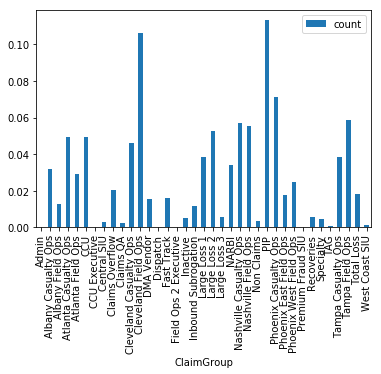

In [143]:
# severity of accidents 
claimgroup_df=general_df[['ClaimID_RGEN','ClaimGroup']].groupby('ClaimGroup').count()
# total claim
total_claim=claimgroup_df['ClaimID_RGEN'].sum()
# change it to percentage share by claimgroup
claimgroup_df['ClaimID_RGEN']=claimgroup_df['ClaimID_RGEN']/total_claim

# rename columns and then plot
claimgroup_df.rename(columns={'ClaimID_RGEN':'count'},inplace=True)
claimgroup_df.plot(kind='bar')

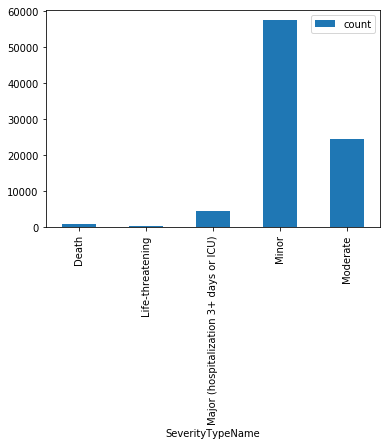

In [144]:
# severity of accidents 
severity_df=general_df[['ClaimID_RGEN','SeverityTypeName']].groupby('SeverityTypeName').count()
# rename columns and then plot
severity_df.rename(columns={'ClaimID_RGEN':'count'},inplace=True)
severity_df.plot(kind='bar')

In [145]:
# severity of accidents 
severity_byState=general_df[['StateName','SeverityTypeName','ClaimID_RGEN']].groupby(['StateName','SeverityTypeName']).count()
severity_byState.head()

ClaimID_RGEN
StateName SeverityTypeName                                    
Alabama   Death                                             16
          Life-threatening                                  10
          Major (hospitalization 3+ days or ICU)           109
          Minor                                           1001
          Moderate                                         389

In [146]:
# rename columns and then plot
severity_byState.rename(columns={'ClaimID_RGEN':'count'},inplace=True)
severity_byState=severity_byState.reset_index()
severity_byState_death=severity_byState[severity_byState.SeverityTypeName=='Major (hospitalization 3+ days or ICU)']

severity_byState_death=severity_byState_death[['StateName','count']]
severity_byState_death=severity_byState_death.set_index('StateName')
severity_byState_death.head()

,count
StateName,
Alabama,109
Alaska,5
Arizona,176
Arkansas,10
California,216


Text(0,0.5,'number of accidents')

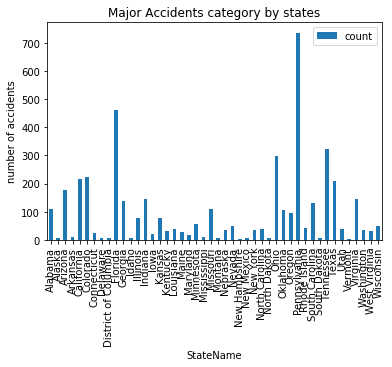

In [147]:
severity_byState_death.plot(kind='bar')
plt.title('Major Accidents category by states')
plt.ylabel('number of accidents')

In [148]:
general_df['SeverityTypeName'].unique()

array(['Moderate', 'Minor', nan, 'Major (hospitalization 3+ days or ICU)',
       'Death', 'Life-threatening'], dtype=object)

In [149]:
general_df['InjuryDescription'] .dtype

dtype('O')

In [150]:
general_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120657 entries, 0 to 120656
Data columns (total 14 columns):
ClaimID_RGEN           120657 non-null int64
ExposureID_RGEN        120657 non-null int64
ClaimLevelBody         120657 non-null object
ExposureLevelBody      111199 non-null object
AccidentDescription    120657 non-null object
InjuryDescription      120619 non-null object
DamageDescription      120657 non-null object
SeverityTypeName       87699 non-null object
ClaimGroup             120642 non-null object
FaultRatingName        120656 non-null object
LossCauseName          120657 non-null object
CCCreateTime           120657 non-null object
CloseDate              99611 non-null object
StateName              120657 non-null object
dtypes: int64(2), object(12)
memory usage: 12.9+ MB


In [151]:
general_df['InjuryDescription'].dtype

dtype('O')

In [152]:
# lower the texts in the column
general_df['AccidentDescription'] = general_df['AccidentDescription '].str.lower() 

In [153]:
# remove if there is any space before and after the texts
general_df['AccidentDescription'] =general_df['AccidentDescription'].str.strip()

In [154]:
general_df['AccidentDescription'] =general_df['AccidentDescription'].replace('[^\w\s]',regex=True)


In [155]:
# let's remove stop words from tokenized words.
from nltk.corpus import stopwords

# let's download stop words
nltk.download('stopwords')
# set up stop words to enlish stop words
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fevty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### to apply spilt or word_tokenize to a column , you should change it to string type using astype(str)

In [193]:
# remove the stops words from Injury description column and assing it back to general_df

general_df['AccidentDescription'] = general_df['AccidentDescription'].astype(str).apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

### predict causes of loss one by one
## mute and unmute one at a time

In [259]:
# insured vehicle rear end claimant vehicle
general_df['losscause'] = np.where(general_df['LossCauseName']=='IV rear-end CV',1,0)
# collision at intersection or others
#general_df['losscause'] = np.where(general_df['LossCauseName']=='Collision in an intersection',1,0)
# if the cause is 'Collision with motor vehicle'
# general_df['losscause'] = np.where(general_df['LossCauseName']=='Collision with motor vehicle',1,0)

In [260]:
# map severity levels to numeric
            
##general_df['LossCauseName']=general_df.SeverityTypeName.map({'Death':0,'Life-threatening':1,'Major (hospitalization 3+ days or ICU)':2,'Minor':3,'Moderate':4})


In [261]:
general_df.isna().sum()

ClaimID_RGEN               0
ExposureID_RGEN            0
ClaimLevelBody             0
ExposureLevelBody       9458
AccidentDescription        0
InjuryDescription          0
DamageDescription          0
SeverityTypeName       32958
ClaimGroup                15
FaultRatingName            1
LossCauseName              0
CCCreateTime               0
CloseDate              21046
StateName                  0
losscause                  0
dtype: int64

In [262]:
# Define X and Y

X=general_df['InjuryDescription']
y=general_df['losscause']


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=42)

In [265]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
#from sklearn.metrics import Score
#Train and evaluate the model
vect = CountVectorizer().fit(X_train)
X_train_vectorized = vect.transform(X_train)
clfrNB = MultinomialNB(alpha = 0.1)
clfrNB.fit(X_train_vectorized, y_train)
pred = clfrNB.predict(vect.transform(X_test))
score = metrics.accuracy_score(y_test,pred)
print(score)
cm=confusion_matrix(y_test, pred)
print(cm)

auc = roc_auc_score(y_test, pred)
print(auc)

0.7216144538372286
[[24391  2573]
 [ 7504  1730]]
0.545963783058662


In [258]:
# compare actual with predicted
diff_iv_read_end_cv=(24391-30669)/30669
print(diff_iv_read_end_cv)
diff_coll_intersec=(29838-19367)/19367
print(diff_coll_intersec)

diff_collision_w_motor_vhcle=(30500-17548)/17548   
print(diff_collision_w_motor_vhcle)


-0.20470181616616126
0.5406619507409511
0.7380898108046501


In [114]:
general_df['InjuryDescription_tokens']=general_df['InjuryDescription'].astype(str).apply(nltk.word_tokenize)

In [115]:
general_df['InjuryDescription_tokens']

0                                                [neckback]
1                                                    [pain]
2                                                  [strain]
3                                                    [back]
4                                              [neck, back]
5                                              [neck, back]
6                                              [back, pain]
7                                                 [unknown]
8                           [sorenessribs, shoulders, back]
9         [checked, ambulance, seat, belt, burn, car, seat]
10                                    [soreness, treatment]
11                                           [neck, injury]
12                                             [neck, pain]
13                                              [hit, head]
14          [upper, back, pain, stiffness, shoulders, neck]
15        [right, wrist, forearm, fracture, right, shoul...
16        [fracture, foot, reinjured, st

In [ ]:
## test['tweet'].apply(lambda x: [item for item in x if item not in stop])

In [118]:
from collections import Counter

In [257]:
general_df['word_counts_InjuryDescr'] = [dict(Counter(doc)) for doc in general_df['InjuryDescription_tokens']]

KeyError: 'InjuryDescription_tokens'

In [256]:
general_df['word_counts_InjuryDescr']

KeyError: 'word_counts_InjuryDescr'

In [124]:
from gensim.corpora.dictionary import Dictionary 

In [127]:
dictionary = Dictionary(general_df['InjuryDescription_tokens'])
print(dictionary.token2id)

{'neckback': 0, 'pain': 1, 'strain': 2, 'back': 3, 'neck': 4, 'unknown': 5, 'shoulders': 6, 'sorenessribs': 7, 'ambulance': 8, 'belt': 9, 'burn': 10, 'car': 11, 'checked': 12, 'seat': 13, 'soreness': 14, 'treatment': 15, 'injury': 16, 'head': 17, 'hit': 18, 'stiffness': 19, 'upper': 20, 'forearm': 21, 'fracture': 22, 'right': 23, 'shoulder': 24, 'side': 25, 'wrist': 26, 'face': 27, 'foot': 28, 'reinjured': 29, 'sternum': 30, 'ankle': 31, 'brused': 32, 'chest': 33, 'sprained': 34, 'hurting': 35, 'left': 36, 'leg': 37, 'drainage': 38, 'ear': 39, 'headaches': 40, 'er': 41, 'fever': 42, 'get': 43, 'high': 44, 'went': 45, 'bruising': 46, 'ems': 47, 'hip': 48, 'transported': 49, 'none': 50, '**': 51, 'broken': 52, 'knocked': 53, 'nose': 54, 'stitches': 55, 'unconscious': 56, 'needed': 57, 'oxygen': 58, 'previous': 59, 'surgery': 60, 'soft': 61, 'sprain': 62, 'tissue': 63, 'lash': 64, 'whip': 65, 'accute': 66, 'hospital': 67, 'soar': 68, 'injuries': 69, 'backhas': 70, 'seet': 71, 'airbag': 72

In [128]:
corpus = [dictionary.doc2bow(doc) for doc in general_df['InjuryDescription_tokens']]

In [129]:
corpus

[[(0, 1)],
 [(1, 1)],
 [(2, 1)],
 [(3, 1)],
 [(3, 1), (4, 1)],
 [(3, 1), (4, 1)],
 [(1, 1), (3, 1)],
 [(5, 1)],
 [(3, 1), (6, 1), (7, 1)],
 [(8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2)],
 [(14, 1), (15, 1)],
 [(4, 1), (16, 1)],
 [(1, 1), (4, 1)],
 [(17, 1), (18, 1)],
 [(1, 1), (3, 1), (4, 1), (6, 1), (19, 1), (20, 1)],
 [(21, 1), (22, 1), (23, 3), (24, 1), (25, 1), (26, 1)],
 [(1, 1), (3, 1), (4, 1), (22, 1), (27, 1), (28, 1), (29, 1), (30, 1)],
 [(1, 1), (3, 1), (4, 1), (31, 1), (32, 1), (33, 1), (34, 1)],
 [(35, 1), (36, 1), (37, 1)],
 [(3, 1), (4, 1), (26, 1), (33, 1), (38, 1), (39, 1), (40, 1)],
 [(5, 1)],
 [(12, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1)],
 [(4, 1), (24, 1), (25, 1), (36, 1)],
 [(1, 1), (3, 1)],
 [(3, 1), (4, 1)],
 [(3, 1), (4, 1), (24, 1), (33, 1), (46, 1), (47, 1), (48, 1), (49, 1)],
 [(50, 1)],
 [(1, 1), (3, 1), (4, 1)],
 [(1, 1), (3, 1), (4, 1)],
 [(51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1)],
 [(47, 1), (49, 1), (57, 1), (58, 1), (59, 1),

In [130]:
# import Tfidf model from gensim.models.tfidfmodel

from gensim.models.tfidfmodel import TfidfModel

In [135]:
# give weights to  tokens infifth line in my documents 
tfidf=TfidfModel(corpus)
# calculate tfidf weights by passing corpus to tfidf
tfidf[corpus[4]]

[(3, 0.6912122904163737), (4, 0.7226517623152598)]

                                       count
LossCauseName                               
CV rear-end IV                          9927
Collision in an intersection           19367
Collision while backing                 3150
Collision while merging / lane change  10694
Collision while turning left            7634
Collision with a parked car             1358
Collision with bicycle / motorcycle      832
Collision with fixed object             5960
Collision with motor vehicle           17548
Collision with pedestrian               2406
Collision with train or bus              107
Damage in loading / unloading             27
Falling or moving object                 312
Fire                                      48
Glass breakage                            21
Hail                                       1
Hazardous Condition                      864
Hit and Run                             2699
IV Repossessed                             6
IV rear-end CV                         30669
IV struck 

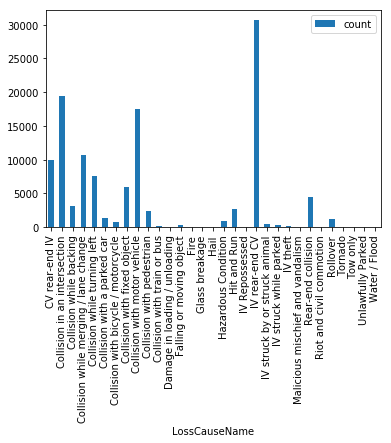

In [235]:
# cause of accidents 
cause_df=general_df[['ClaimID_RGEN','LossCauseName']].groupby('LossCauseName').count()
# rename columns and then plot
cause_df.rename(columns={'ClaimID_RGEN':'count'},inplace=True)
print(cause_df)
cause_df.plot(kind='bar')

In [229]:
cause_df['cause_share']=(cause_df['count'])/(len(general_df))
cause_df=cause_df.drop('count',axis=1).sort_values('cause_share',ascending=False)
cause_df

,cause_share
LossCauseName,
IV rear-end CV,0.254183
Collision in an intersection,0.160513
Collision with motor vehicle,0.145437
Collision while merging / lane change,0.088631
CV rear-end IV,0.082275
Collision while turning left,0.063270
Collision with fixed object,0.049396
Rear-end collision,0.037511
Collision while backing,0.026107


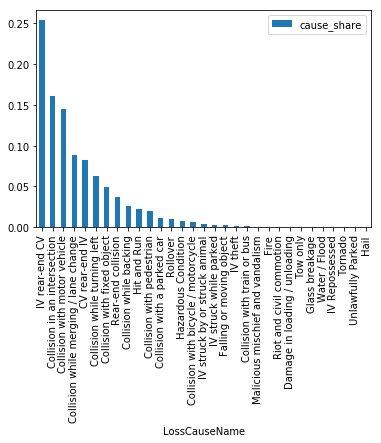

In [230]:
cause_df.plot(kind='bar')

In [209]:
len(general_df)

120657

In [ ]:
general_df['LossCauseName']=general_df.LossCauseName.map

In [ ]:
nltk.download('punkt')

In [ ]:
# who was at fault
fualts=general_df[['ClaimID_RGEN','FaultRatingName']].groupby('FaultRatingName').count()
#.rename(columns=('ClaimID_RGEN':'count',inplace=True)
fualts.rename(columns={'ClaimID_RGEN':'count'},inplace=True)
fualts.plot(kind='bar')